In [1]:
import numpy as np
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from tqdm import tqdm

from numpy_resnet import ResNet, resnet101

from NumpyNN.NN_np import (
    FullyConnectedLayer,
    ReLULayer,
    SigmoidLayer,
    ReLULayer,
    AdamOptimizer,
    CrossEntropyLoss,
    LinearActivation,
    Sequential,
    Optimizer,
    SoftMaxLayer,
    GradientDescentOptimizer,
    CrossEntropyLossWithSoftMax,
    softmax,
    Conv2d,
    Flatten
)

In [2]:
plt.gray()

<Figure size 432x288 with 0 Axes>

In [3]:
def one_hot(y: np.ndarray, n_classes: int):
    encoded = np.zeros((y.size, n_classes))
    encoded[np.arange(y.size), y] = 1
    return encoded

In [4]:
((X_train, y_train), (X_test, y_test)) = mnist.load_data()

X_train = X_train.reshape(-1, 1, 28, 28)
X_test = X_test.reshape(-1, 1, 28, 28)
y_train = one_hot(y_train, 10)
y_test = one_hot(y_test, 10)

In [5]:
y_train.shape, X_train.shape

((60000, 10), (60000, 1, 28, 28))

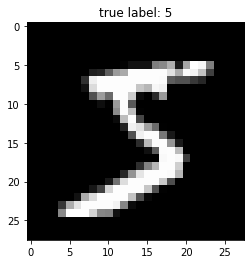

In [6]:
plt.title(f"true label: {np.argmax(y_train[0])}")
plt.imshow(X_train[0].reshape(28, 28))

In [7]:
# # The history is calculated for batches in implementation below

# def train(model, X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray, y_test: np.ndarray,
#           optimizer: Optimizer, loss, epochs: int, batch_size: int):

#     metric_names = ['loss', 'accuracy', 'f1_score']
#     history = {phase_name: {metric_name: [] for metric_name in metric_names} for phase_name in ['train', 'test']}

#     for i in range(epochs):
#         epoch_loss = 0
#         for j in tqdm(range(0, X_train.shape[0], batch_size)):
#             for phase in ['train', 'test']:
#                 # print(f"epoch {i} batch {j}")
#                 if phase == 'train':
#                     X, y = X_train[j:j+batch_size], y_train[j:j+batch_size]
#                 elif phase == 'test':
#                     X, y = X_test, y_test

#                 y_pred = model.forward(X)
#                 loss_val = loss.forward(y_pred, y)

#                 y_pred_label_b = np.argmax(y_pred, axis=1)
#                 y_true_label_b = np.argmax(y, axis=1)

#                 history[phase]['accuracy'].append(np.mean(np.array(y_pred_label_b) == np.array(y_true_label_b)))
#                 history[phase]['loss'].append(loss_val)
#                 history[phase]['f1_score'].append(f1_score(y_pred_label_b, y_true_label_b, average='macro'))

#                 if phase == 'train':
#                     loss_gradient = loss.backward()
#                     model.backward(loss_gradient)
#                     optimizer.step()
#     return history

In [8]:
# The history is calculated for the whole epoch in implementation below

def train(model, X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray, y_test: np.ndarray,
          optimizer: Optimizer, loss, epochs: int, batch_size: int):

    metric_names = ['loss', 'accuracy', 'f1_score']
    history = {phase_name: {metric_name: [] for metric_name in metric_names} for phase_name in ['train', 'test']}

    for i in range(epochs):
        for phase in ['train', 'test']:
            y_pred_labels = []
            y_true_labels = []
            epoch_loss = 0
            if phase == 'train':
                X, y = X_train, y_train
            elif phase == 'test':
                X, y = X_test, y_test
            for j in tqdm(range(0, X.shape[0], batch_size)):
                X_b = X[j:j+batch_size]
                y_b = y[j:j+batch_size]
                y_pred = model.forward(X_b)
                loss_val = loss.forward(y_pred, y_b)

                y_pred_label_b = np.argmax(y_pred, axis=1)
                y_true_label_b = np.argmax(y_b, axis=1)

                epoch_loss += loss_val.item()
                y_pred_labels.extend(y_pred_label_b)
                y_true_labels.extend(y_true_label_b)

                if phase == 'train':
                    loss_gradient = loss.backward()
                    model.backward(loss_gradient)
                    optimizer.step()

            history[phase]['accuracy'].append(np.mean(np.array(y_pred_labels) == np.array(y_true_labels)))
            history[phase]['loss'].append(loss_val)
            history[phase]['f1_score'].append(f1_score(y_pred_labels, y_true_labels, average='macro'))

            
    return history

In [9]:
# Conv2d.backward = Conv2d.backward_as_mat_mul_unified

In [10]:
in_channels = 1
out_channels = 32
kernel_size = 3
stride = 1
padding = 1
bias = True

height = X_train[0].shape[1]
width = X_train[0].shape[2]

batch_size = 1024
epochs = 3
weights_data = []

model = Sequential([
    Conv2d(in_channels, out_channels, kernel_size, stride, padding), ReLULayer(),
    # Conv2d(out_channels, out_channels, kernel_size, stride, padding), ReLULayer(),
    Flatten(), FullyConnectedLayer(height * width * out_channels, 10)])
# optimizer = GradientDescentOptimizer(model.trainable_layers, learning_rate = 1e-3)
optimizer = AdamOptimizer(model.trainable_layers, learning_rate = 1e-3)
loss = CrossEntropyLossWithSoftMax()

history = train(model, X_train, y_train, X_test, y_test, optimizer, loss, epochs, batch_size)

100%|██████████| 10/10 [00:34<00:00,  3.46s/it]


In [15]:
# history2 = train(model, X_train, y_train, X_test, y_test, optimizer, loss, 2, batch_size)
# for phase in ['train', 'test']:
#     for key in history[phase]:
#         history[phase][key].extend(history2[phase][key])

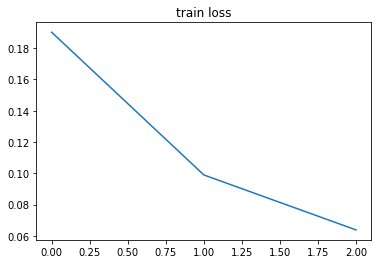

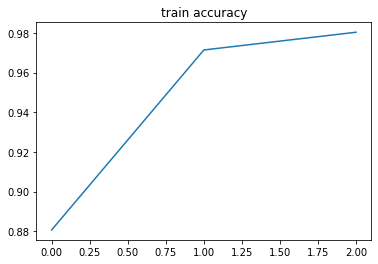

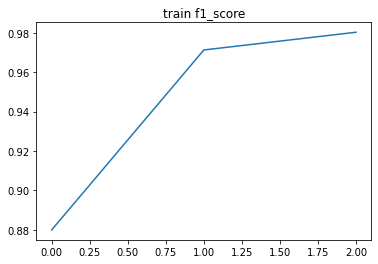

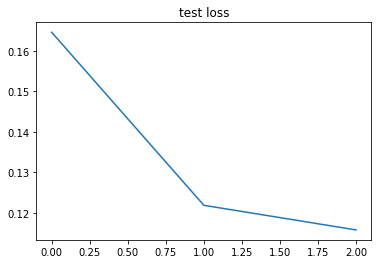

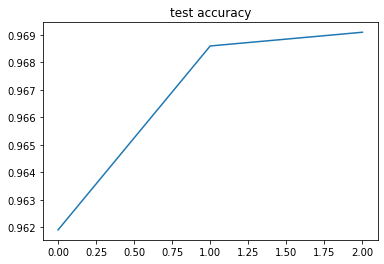

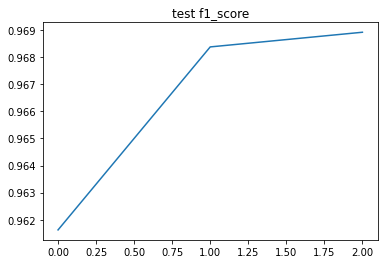

In [14]:
for phase in ['train', 'test']:
    for key, value in history[phase].items():
        plt.plot(value)
        plt.title(f"{phase} {key}")
        plt.show()

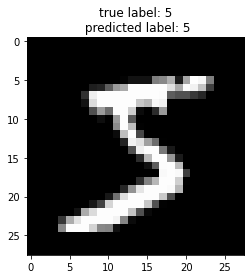

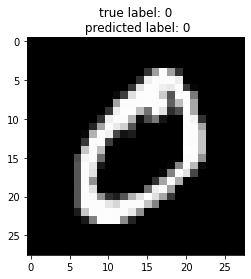

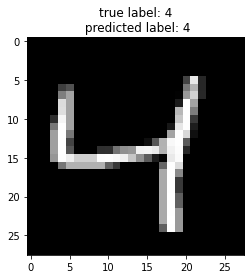

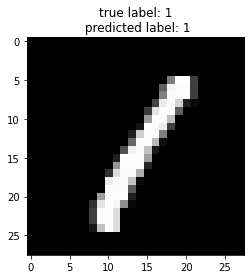

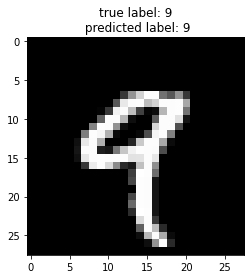

In [13]:
for i in range(5):
    probs_i = softmax(model.forward(X_train[i].reshape(1, 1, 28, 28)))
    plt.title(f"true label: {np.argmax(y_train[i])}\n predicted label: {np.argmax(probs_i)}")
    plt.imshow(X_train[i].reshape(28, 28))
    plt.show()

In [7]:
import torch

c:\Users\SystemPoint\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
X_train_torch = torch.from_numpy(X_train).float()
y_train_torch = torch.from_numpy(y_train)

X_test_torch = torch.from_numpy(X_test).float()
y_test_torch = torch.from_numpy(y_test)

def train_torch(model, X_train: torch.Tensor, y_train: torch.Tensor, X_test: torch.Tensor, y_test: torch.Tensor,
          optimizer, loss, epochs: int, batch_size: int):
    
    metric_names = ['loss', 'accuracy', 'f1_score']
    history = {phase_name: {metric_name: [] for metric_name in metric_names} for phase_name in ['train', 'test']}

    for i in range(epochs):
        for j in tqdm(range(0, X_train.shape[0], batch_size)):
            # print(f"epoch {i} batch {j}")
            X_b_train = X_train[j:j+batch_size]
            y_b_train = y_train[j:j+batch_size]
            y_pred = model(X_b_train)
            loss_val = loss(y_pred, y_b_train)
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            y_pred_label = np.argmax(y_pred.detach().numpy(), axis=1)
            y_true_label = np.argmax(y_b_train.detach().numpy(), axis=1)

            history['train']['accuracy'].append(np.mean(y_pred_label == y_true_label).item())
            history['train']['loss'].append(loss_val.item())
            history['train']['f1_score'].append(f1_score(y_true_label, y_pred_label, average='macro').item())
            
    return history

In [9]:
np.argmax([[1, 2, 3], [4, 5, 6]], axis = 0)

array([1, 1, 1], dtype=int64)

In [10]:
X_train_torch.dtype

torch.float32

In [12]:
in_channels = 1
out_channels = 32
kernel_size = 3
stride = 1
padding = 1
bias = True

height = X_train[0].shape[1]
width = X_train[0].shape[2]

batch_size = 1024
epochs = 3

model_torch = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
    torch.nn.ReLU(),
    torch.nn.Flatten(), 
    torch.nn.Linear(height * width * out_channels, 10),
)

weights_data_torch = []

optimizer_torch = torch.optim.Adam(model_torch.parameters(), lr=1e-3)

loss_torch = torch.nn.CrossEntropyLoss()

history_torch = train_torch(model_torch, X_train_torch, y_train_torch, X_test_torch, y_test_torch, optimizer_torch, loss_torch, epochs, batch_size)

100%|██████████| 59/59 [00:39<00:00,  1.49it/s]


In [ ]:
# list(model_torch.parameters())

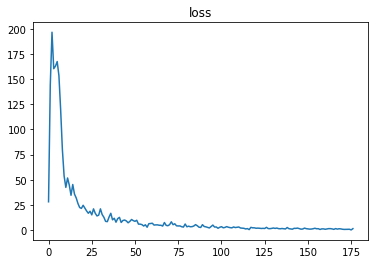

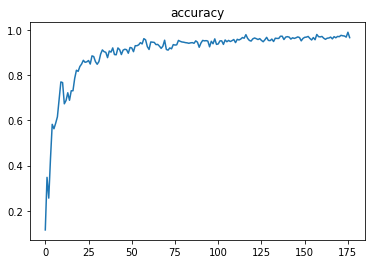

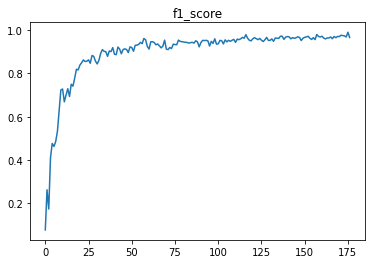

In [51]:
for key, value in history_torch['train'].items():
    plt.plot(value)
    plt.title(key)
    plt.show()